# Orbital velocity analysis
Investigate departure of orbital velocities from Vectors and Signatures on the small-scale array rock from linear wave theory (LWT) predictions.

In [7]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
# from mat73 import loadmat
from scipy.io import loadmat
from scipy import stats, signal
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as tck
from roxsi_pyfuns.plotting import multiple_formatter
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf
from roxsi_pyfuns import plotting as rppl

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
mdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/mfiles'
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
figdir = os.path.join(vec_root, 'img')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))


Example figure.

## Wave-by-wave orbital velocities
Use zero-crossings of the sea-surface elevation to get ensemble-averaged orbital velocities from C2, C3 and C4 Vectors. Use amplitudes and wavenumbers of the waves to make LWT predictions of the orbital velocities assuming flat bottom.

Use principal component analysis (PCA) to rotate velocities to cross-shore and vertical components. Use singular value decomposition (SVD) to fit ellipses around orbital velocities, and compute their eccentricity.

In [2]:
# Flags for normalization, depth definition, etc.
norm_flag = False # If True, normalize velocities & eta by std
norm_ind = False # If True, normalize index by H13
depth_def = 'local' # Either 'local' or 'surrounding'
k_surr = False # If True, use surr. d for k, but local d for TRF

# Read C2, C3, C4 Vector data for given date
# t0 = pd.Timestamp('2022-07-17 12:00:00')
# t1 = pd.Timestamp('2022-07-17 19:00:00')
t0 = pd.Timestamp('2022-07-14 17:00:00')
t1 = pd.Timestamp('2022-07-14 18:00:00')

# Define expected headings in PCA coordinates for C2 & C3
heading_exp = {'C2': -125, 'C3': -90}
            
# Read L5 Signature spectrum file for surrounding depth
fn_l5 = os.path.join(rootdir, 'Signatures', 'Level1', '103206', 'Spectra', 
    'Asilomar_2022_SSA_Signature_103206_spec_AST.nc')
dsl5 = xr.decode_cf(xr.open_dataset(fn_l5, decode_coords='all'))

# Serial numbers and corresponding mooring IDs
servs = ['17212', '17219', '17371']#, '17372', '17376', '17377'] # Serial #s of Vectors
mids = ['C2', 'C3', 'C4']#, 'C5', 'L2', 'L4'] # Mooring IDs

# zero-crossing dataframe dictionaries
dfd_e = {'{}'.format(m): [] for m in mids} # Dict for storing eta dataframes for each mid
dfd_e_lin = {'{}'.format(m): [] for m in mids} # Dict for storing lin. eta 
dfd_u = {'{}'.format(m): [] for m in mids} # Dict for storing u 
dfd_u_lin = {'{}'.format(m): [] for m in mids} # Dict for storing lin. u 
dfd_w = {'{}'.format(m): [] for m in mids} # Dict for storing w 
dfd_w_lin = {'{}'.format(m): [] for m in mids} # Dict for storing lin. w 
# Ellipses
dfd_evx = {'{}'.format(m): [] for m in mids} # Dict for storing x-ellipse dataframes for each mid
dfd_elx = {'{}'.format(m): [] for m in mids} # Dict for storing lin. x-ell.
dfd_evy = {'{}'.format(m): [] for m in mids} # Dict for storing y-ellipse 
dfd_ely = {'{}'.format(m): [] for m in mids} # Dict for storing lin. y-ell. 
# Angles and semi axes of ellipses
dfd_ang = {'{}'.format(m): [] for m in mids}
dfd_ang_lin = {'{}'.format(m): [] for m in mids}
# Acceleration of ux
dfd_acc = {'{}'.format(m): [] for m in mids} # Dict for storing u-acc. dataframes for each mid

# Loop over C2, C3, C4 Vectors
for mid, serv in tqdm(zip(mids, servs)):
    print(mid)
    dsl = [] # list for merging/averaging bicoherence dataarrays
    # print('Mooring ID: {}, serial no: {}'.format(mid, serv))
    # Get data dir of daily nc files
    ncdir = os.path.join(vec_root, mid)
    date_range = pd.date_range(t0.floor('1D'), t1.ceil('1D'), freq='1D')
    # Initialize lists for sorting dataframes of interpolated eta, u, w
    dfw_eta_l = []
    dfw_eta_lin_l = []
    dfw_u_l = []
    dfw_u_lin_l = []
    dfw_w_l = []
    dfw_w_lin_l = []
    dfw_ellx_l = [] # x-comp. of ellipses
    dfw_elly_l = [] # y-comp. of ellipses
    dfw_ellx_lin_l = []
    dfw_elly_lin_l = []
    dfw_ang_l = [] # Ellipse rotation angle
    dfw_ang_lin_l = []

    # Iterate over daily nc files
    for date in date_range:
        datestr = DT.strftime(date, '%Y%m%d')
        # print(date)
        # Get netcdf file name
        fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, datestr))
        dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
        # Estimate wave heights from bursts
        burst_range = pd.date_range(date, date+pd.Timedelta(days=1), freq='1H')
        # Iterate over bursts
        for bi, t0b in enumerate(burst_range[:-1]):
            # Take out segment
            t1b = t0b + pd.Timedelta(hours=1)
            if t0b < t0:
                continue
            if t0b >= t1:
                continue
            spec_cols = ['uxd', 'uyd', 'uzd','eta_lin_krms', 'z_hyd', 'heading_ang', 
                         'pitch_ang', 'roll_ang']
            seg = dsv[spec_cols].sel(time=slice(t0b, t1b)).copy()
            depth_surr = dsl5.depth_loc.sel(time=t0b.floor('1H')).item()
            depth_loc = seg.z_hyd.mean().item() + 0.5 # Local depth at instrument
            # print('{} - {}'.format(t0b, t1b))
            # print('depth_surr - depth_loc = ', depth_surr - depth_loc)
            # Use depth_def to decide which depth to use
            if depth_def == 'local':
                # Use local depth for LWT estimates
                depth = depth_loc # Assume local depth at instrument
                zb = 0.5 # Height of instrument above seabed
            elif depth_def == 'surrounding':
                # Use surrounding (L5) depth for LWT estimates
                depth = depth_surr # Assume we're in surrounding water depth (flat bottom)
                zb = depth_surr - depth_loc # Instrument height above flat seabed
            # Get mean heading, pitch, roll angles
            head_ang = seg.heading_ang.copy()
            head_mean = head_ang.mean(dim='time').item()
            pitch_ang = seg.pitch_ang.copy()
            pitch_mean = pitch_ang.mean(dim='time').item()
            roll_ang = seg.roll_ang.copy()
            roll_mean = roll_ang.mean(dim='time').item()
            # Get zero crossings from linear surface reconstruction
            eta = seg.eta_lin_krms.to_dataframe() # Convert to pandas
            eta = eta.interpolate(method='bfill').interpolate('ffill')
            eta -= eta.mean()
            # x vel, despiked
            uxd = seg.uxd.to_dataframe() # Convert to pandas
            uxd = uxd.interpolate(method='bfill').interpolate('ffill')
            uxd -= uxd.mean()
            # y vel, despiked
            uyd = seg.uyd.to_dataframe() # Convert to pandas
            uyd = uyd.interpolate(method='bfill').interpolate('ffill')
            uyd -= uyd.mean()
            # z vel, despiked
            uzd = seg.uzd.to_dataframe() # Convert to pandas
            uzd = uzd.interpolate(method='bfill').interpolate('ffill')
            uzd -= uzd.mean()
            # First rotate velocities based on principal axes
            vel_pca, R, eul = rpct.rotate_pca(ux=uxd.values.squeeze(), 
                                              uy=uyd.values.squeeze(), 
                                              uz=uzd.values.squeeze(),
                                              return_r=True, return_eul=True, )
            # Check if R is left-handed (det(R)=-1) 
            if np.linalg.det(R) < 0 and mid in ['C2', 'C3']: 
                # Check if heading is off relative to expected heading
                if np.abs(heading_exp[mid] - np.rad2deg(eul['eul3'])) > 45:
                    print('Flipping y axis ...')
                    # Redo rotation, but flip y axis
                    vel_pca, R, eul = rpct.rotate_pca(ux=uxd.values.squeeze(), 
                                                      uy=uyd.values.squeeze(), 
                                                      uz=uzd.values.squeeze(),
                                                      return_r=True, 
                                                      return_eul=True, 
                                                      flipy=True,
                                                      ) 
            # Rotate using Euler angles (C2 and C3)
#             if mid != 'C4':
#                 # Only use PCA heading for C2 and C3
#                 vel_pca, _ = rpct.rotate_euler(ux=uxd.values.squeeze(), 
#                                                uy=uyd.values.squeeze(), 
#                                                uz=uzd.values.squeeze(),
#                                                eul1=np.deg2rad(pitch_mean), 
#                                                eul2=np.deg2rad(roll_mean), 
#                                                eul3=eul['eul3'])
            # Assume u_pc1=ucs, u_pc2=uls, u_pc3=uw
            ucs = vel_pca[:,0].copy()
            uls = vel_pca[:,1].copy()
            uw = vel_pca[:,2].copy()
            # Check if some component(s) need to be flipped
            if np.abs(np.rad2deg(eul['eul1'])) > 90:
                # z-axis points downward -> flip vertical velocity
                print('Flipping vertical velocity ... ')
                uw *= (-1)
            if np.abs(np.rad2deg(eul['eul2'])) > 90:
                # z-axis points downward -> flip vertical velocity
                print('Flipping vertical velocity ... ')
                uw *= (-1)
            # Check if heading is off if det(R) = 1
            if np.linalg.det(R) > 0 and mid in ['C2', 'C3']:
                if np.abs(heading_exp[mid] - np.rad2deg(eul['eul3'])) > 90:
                    print('Flipping horizontal velocity ... ')
                    ucs *= (-1)
            # Compute coherence and phase to check components
            spec_r = rpws.spec_uvz(z=uw, u=ucs, v=uls, fs=16)
            # Get index of max. coherence^2 b/w ucs and uw
            ind_mcu = np.argmax((spec_r.coh_uz**2).sel(freq=slice(0.05, 0.3)).values).item()
            ind_mcv = np.argmax((spec_r.coh_vz**2).sel(freq=slice(0.05, 0.3)).values).item()
            # Compute ucs-uw phase at max coherence
            pmc = np.rad2deg(spec_r.ph_uz.sel(freq=slice(0.05, 0.3)).isel(freq=ind_mcu).item())
            # If phase is +90 -> flip ux velocity
            if pmc > 0:
                ucs *= (-1)
                # Compute coherence and phase again
                spec_r = rpws.spec_uvz(z=uw, u=ucs, v=uls, fs=16)
                pmc = np.rad2deg(spec_r.ph_uz.sel(freq=slice(0.05, 0.3)).isel(freq=ind_mcu).item())
            # Print ucs-uw phase at max coherence
            print('ucs-uw phase at max coh: {:.2f}'.format(pmc))
            # Skip if no eta
            if np.all(np.isnan(eta)):
                print('all nan eta')
                continue
            # Zero-crossing (up) wave heights
            zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=3*16)
            # Compute H(1/3)
            Hws = np.sort(Hw) # Sorted wave heights
            H13 = np.mean(Hws[2*(len(Hw)//3):]) # Mean of highest 1/3 of waves
            # Normalize wave heights by H13?
            if norm_ind:
                Hw /= H13
            # Define phase (x) axis to interpolate to
            x_phase = np.linspace(0, 2*np.pi, 160)

            # Make dataframes for angles, semi axes, eccentricity, KC number and aspect ratio 
            # of ellipses fit to each wave's orbital excursions
            nw = len(zc[:-1]) # number of waves
            # Normalize index by H13?
            dfw_ang = pd.DataFrame(data={'ang':np.zeros(nw), 
                                         'a':np.zeros(nw), 
                                         'b':np.zeros(nw),
                                         'ecc':np.zeros(nw),
                                         'ar':np.zeros(nw),
                                         'kc':np.zeros(nw),
                                         'dloc':np.zeros(nw), # local depth
                                         }, 
                                   index=Hw
                                   )
            # Linear estimates
            dfw_ang_lin = pd.DataFrame(data={'ang':np.zeros(nw), 
                                             'a':np.zeros(nw), 
                                             'b':np.zeros(nw),
                                             'ecc':np.zeros(nw),
                                             'ar':np.zeros(nw),
                                             'kc':np.zeros(nw),
                                             'dloc':np.zeros(nw), # local depth
                                             }, 
                                       index=Hw
                                       )

            # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
            for zi,zc0 in enumerate(zc[:-1]):
                # Wave surface elevation, u and w for current wave
                eta_wave = eta.iloc[zc0:zc[zi+1]]
                u_wave = ucs[zc0:zc[zi+1]]
                w_wave = uw[zc0:zc[zi+1]]
                # Define phase x axis of wave
                x_wave = np.linspace(0, 1, len(eta_wave)) * 2*np.pi
                # Interpolate to regular phase
                eta_interp = np.interp(x_phase, x_wave, eta_wave.squeeze())
                u_interp = np.interp(x_phase, x_wave, u_wave.squeeze())
                w_interp = np.interp(x_phase, x_wave, w_wave.squeeze())

                # Normalize velocities and surface elevation?
                if norm_flag:
                    # Norm. by std()
                    # eta_interp /= np.std(eta.values)
                    eta_interp /= np.std(eta_interp)
                    # u_interp /= np.std(ucs)
                    u_interp /= np.std(u_interp)
                    # w_interp /= np.std(uw)
                    w_interp /= np.std(w_interp)

                # Fit ellipse using SVD
                ellipse_vec, angle_vec, av, bv = rppl.fit_ellipse_svd(u_interp, w_interp,)
                # Save angles and semi axes to dataframe
                dfw_ang['ang'].iloc[zi] = angle_vec
                dfw_ang['a'].iloc[zi] = av
                dfw_ang['b'].iloc[zi] = bv
                # Also save eccentricity
                dfw_ang['ecc'].iloc[zi] = np.sqrt(1 - bv**2/av**2)
                dfw_ang['ar'].iloc[zi] = av / bv
                # Save local depth
                dfw_ang['dloc'].iloc[zi] = depth_loc
                # Check if ellipse needs to be flipped (for consistency when averaging)
                if np.cos(angle_vec) > 0:
                    evx = ellipse_vec[:,0] # x values
                    evy = ellipse_vec[:,1] # y values
                else:
                    evx = -ellipse_vec[:,0] # x values
                    evy = -ellipse_vec[:,1] # y values

                # Save interpolated eta, u_cs and w for each wave in dataframe
                dfw_eta = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): eta_interp}, 
                    index=x_phase)
                dfw_u = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): u_interp}, 
                    index=x_phase)
                dfw_w = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): w_interp}, 
                    index=x_phase)
                # Save ellipses for each wave in dataframe
                dfw_ell_x = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): evx}, 
                    index=x_phase)
                dfw_ell_y = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): evy}, 
                    index=x_phase)
                # Append to lists
                dfw_eta_l.append(dfw_eta)
                dfw_u_l.append(dfw_u)
                dfw_w_l.append(dfw_w)
                dfw_ellx_l.append(dfw_ell_x)
                dfw_elly_l.append(dfw_ell_y)

                # Compute theoretical LWT values
                fs = 16 # sampling freq.
                T = ((zc[zi+1] - zc0)/16) # wave period in sec.
                omega = 2*np.pi / T # Radian freq. of current wave
                amp = Hw[zi] / 2 # Amplitude from wave height
                t = np.linspace(0, 1, len(x_phase)) * T # time axis
                # Linear surface elevation profile
                eta_lin = amp * np.sin(omega * t) 
                etan_lin = eta_lin / np.std(eta.values)
                # Theoretical velocities
                if depth_def == 'local' and k_surr:
                    # Use local depth for TRF but surrounding depth for k
                    k_lin = rpws.waveno_full(omega, d=depth_surr)
                else:
                    k_lin = rpws.waveno_full(omega, d=depth)
                # u vel. with local depth
                u_lin = (omega * amp * (np.cosh(k_lin * zb) / 
                    np.sinh(k_lin * depth)) * eta_lin)
                # Waveform for w
                eta_lin_w = np.cos(omega * t) 
                # vertical vel. w/ local depth
                w_lin = (omega * amp * (np.sinh(k_lin * zb) / 
                    np.sinh(k_lin * depth)) * eta_lin_w)

                # Normalize linear velocities and surface elevation?
                if norm_flag:
                    # Norm. by std()
                    # eta_lin /= np.std(eta.values)
                    eta_lin /= np.std(eta_interp)
                    # u_lin /= np.std(ucs)
                    u_lin /= np.std(u_interp)
                    # w_lin /= np.std(uw)
                    w_lin /= np.std(w_interp)

                # Fit ellipse using SVD
                ellipse_lin, angle_lin, al, bl = rppl.fit_ellipse_svd(u_lin, w_lin,)
                # Save angles and semi axes to dataframe
                dfw_ang_lin['ang'].iloc[zi] = angle_lin
                dfw_ang_lin['a'].iloc[zi] = al
                dfw_ang_lin['b'].iloc[zi] = bl
                # Also save eccentricity and aspect ratio
                dfw_ang_lin['ecc'].iloc[zi] = np.sqrt(1 - bl**2/al**2)
                dfw_ang_lin['ar'].iloc[zi] = al / bl
                # Save local depth
                dfw_ang_lin['dloc'].iloc[zi] = depth_loc
                if np.cos(angle_lin) > 0:
                    elx = ellipse_lin[:,0] # x values
                    ely = ellipse_lin[:,1] # y values
                else:
                    # Multiply by -1 to get correct orientation
                    elx = -ellipse_lin[:,0] # x values
                    ely = -ellipse_lin[:,1] # y values

                # Save in dataframes
                dfw_eta_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): eta_lin}, 
                    index=x_phase)
                dfw_u_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): u_lin}, 
                    index=x_phase)
                dfw_w_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): w_lin}, 
                    index=x_phase)

                # Save ellipses for each wave in dataframe
                dfw_ell_x_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): elx}, 
                    index=x_phase)
                dfw_ell_y_lin = pd.DataFrame(data={'{:.2f}'.format(Hw[zi]): ely}, 
                    index=x_phase)

                # Append to list
                dfw_eta_lin_l.append(dfw_eta_lin)
                dfw_u_lin_l.append(dfw_u_lin)
                dfw_w_lin_l.append(dfw_w_lin)
                dfw_ellx_lin_l.append(dfw_ell_x_lin)
                dfw_elly_lin_l.append(dfw_ell_y_lin)

            # Append angles and semi axes dataframes to lists for concatenating
            dfw_ang_l.append(dfw_ang)
            dfw_ang_lin_l.append(dfw_ang_lin)

    # Concatenate dataframes
    dfd_e[mid] = pd.concat(dfw_eta_l, axis=1)
    dfd_e_lin[mid] = pd.concat(dfw_eta_lin_l, axis=1)
    dfd_u[mid] = pd.concat(dfw_u_l, axis=1)
    dfd_u_lin[mid] = pd.concat(dfw_u_lin_l, axis=1)
    dfd_w[mid] = pd.concat(dfw_w_l, axis=1)
    dfd_w_lin[mid] = pd.concat(dfw_w_lin_l, axis=1)
    # Ellipses
    dfd_evx[mid] = pd.concat(dfw_ellx_l, axis=1)
    dfd_evy[mid] = pd.concat(dfw_elly_l, axis=1)
    dfd_elx[mid] = pd.concat(dfw_ellx_lin_l, axis=1)
    dfd_ely[mid] = pd.concat(dfw_elly_lin_l, axis=1)
    # Angles and semi axes
    dfd_ang[mid] = pd.concat(dfw_ang_l, axis=0)
    dfd_ang[mid].index = dfd_ang[mid].index.rename('Hw')
    dfd_ang_lin[mid] = pd.concat(dfw_ang_lin_l, axis=0)
    dfd_ang_lin[mid].index = dfd_ang_lin[mid].index.rename('Hw')




0it [00:00, ?it/s]

C2
Flipping vertical velocity ... 
Flipping horizontal velocity ... 
ucs-uw phase at max coh: -89.82
C3
Flipping y axis ...
ucs-uw phase at max coh: -106.72
C4
ucs-uw phase at max coh: -92.26


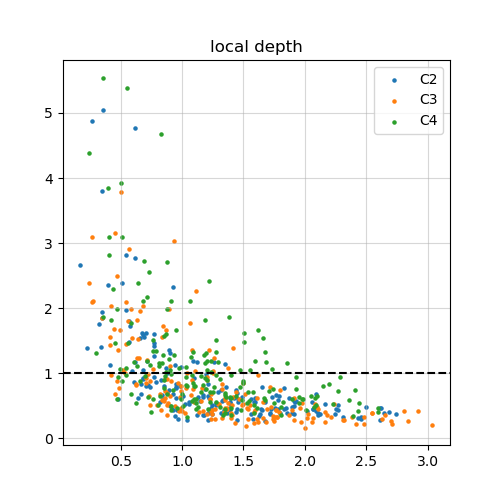

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter((dfd_ang_lin['C2'].index ),#/ dfd_ang_lin['C2']['dloc']), 
           (dfd_ang['C2']['ar'] / dfd_ang_lin['C2']['ar']), 
           s=5, label='C2')
ax.scatter((dfd_ang_lin['C3'].index ),#/ dfd_ang_lin['C3']['dloc']), 
           (dfd_ang['C3']['ar'] / dfd_ang_lin['C3']['ar']), 
           s=5, label='C3')
ax.scatter((dfd_ang_lin['C4'].index ),#/ dfd_ang_lin['C4']['dloc']), 
           (dfd_ang['C4']['ar'] / dfd_ang_lin['C4']['ar']), 
           s=5, label='C4')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.axhline(1, color='k', linestyle='--')
ax.legend()
ax.grid(alpha=0.5)
if norm_flag:
    ax.set_title('{} depth, normalized'.format(depth_def))
else:
    if k_surr and depth_def == 'local':
        ax.set_title('{} depth, '.format(depth_def) + r'$k_\mathrm{surr}$')
    else:
        ax.set_title('{} depth'.format(depth_def))

plt.show()


Ensemble-averaged phase plot.

In [8]:
# Mooring ID to plot
mid = 'C3'
# Line colors for small, medium and large waves
cls = ['#6699CC', '#FF8C42', '#A23E48']

# Initialize figure
fig, axes = plt.subplots(figsize=(6,6), nrows=3, sharex=True)
N = len(dfd_e[mid].keys())
# Surf. elevation (mean)
l1 = dfd_e[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.5,
    color=cls[0], label=r'$H_\mathrm{1/3-low}$')
dfd_e_lin[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.0, 
    color=cls[0], linestyle='--', label='_') # Linear (harmonic) estimate
l2 = dfd_e[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.5, 
    color=cls[1], label=r'$H_\mathrm{1/3-mid}$')
dfd_e_lin[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[0], linewidth=1.0, 
    color=cls[1], linestyle='--', label='_')
l3 = dfd_e[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[0], linewidth=1.5, 
    color=cls[2], label=r'$H_\mathrm{1/3-high}$')
dfd_e_lin[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[0], linewidth=1.0, 
    color=cls[2], linestyle='--', label='_')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, fontsize=8)
# Cross-shore vel. (ensemble avg)
dfd_u[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.5, 
    color=cls[0])
dfd_u_lin[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.0, 
    color=cls[0], linestyle='--')
dfd_u[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.5, 
    color=cls[1])
dfd_u_lin[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[1], linewidth=1.0, 
    color=cls[1], linestyle='--')
dfd_u[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[1], linewidth=1.5, 
    color=cls[2])
dfd_u_lin[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[1], linewidth=1.0, 
    color=cls[2], linestyle='--')
# Vertical vel. (ensemble avg)
dfd_w[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.5, 
    color=cls[0])
dfd_w_lin[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.0, 
    color=cls[0], linestyle='--')
dfd_w[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.5, 
    color=cls[1])
dfd_w_lin[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).plot(ax=axes[2], linewidth=1.0, 
    color=cls[1], linestyle='--')
dfd_w[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[2], linewidth=1.5, 
    color=cls[2])
dfd_w_lin[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).plot(ax=axes[2], linewidth=1.0, 
    color=cls[2], linestyle='--')

# axis stuff
for ax in axes:
    ax.grid()
    # Set x axis labels as multiples of pi
    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    # Symmetric axis limits
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)

# Compute Hs from highest 33-percentile
H13 = dfd_e[mid].sort_index(axis=1).iloc[:,2*N//3:].columns.to_numpy().astype(float).mean()
axes[0].set_title('{} Vec {}-{}, '.format(
    mid, t0, t1.time()) + r'$H_{1/3}=$' + '{:.2f}'.format(H13))
axes[0].set_ylabel(r'$\langle \eta \rangle$ [m]')
axes[1].set_ylabel(r'$\langle u \rangle$ [m/s]')
axes[2].set_ylabel(r'$\langle w \rangle$ [m]')
axes[-1].set_xlabel('Phase')
axes[0].set_ylim([-1.25, 1.25])
axes[1].set_ylim([-1.5, 1.5])
axes[2].set_ylim([-0.22, 0.22])

plt.tight_layout()
fn_fig = os.path.join(figdir, 'phase_res_vel_{}.png'.format(mid))
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
# plt.show()
plt.close()

Ensemble-averaged orbital excursion (colored by phase) plot.

w-low max: 0.04, w-low min: -0.09


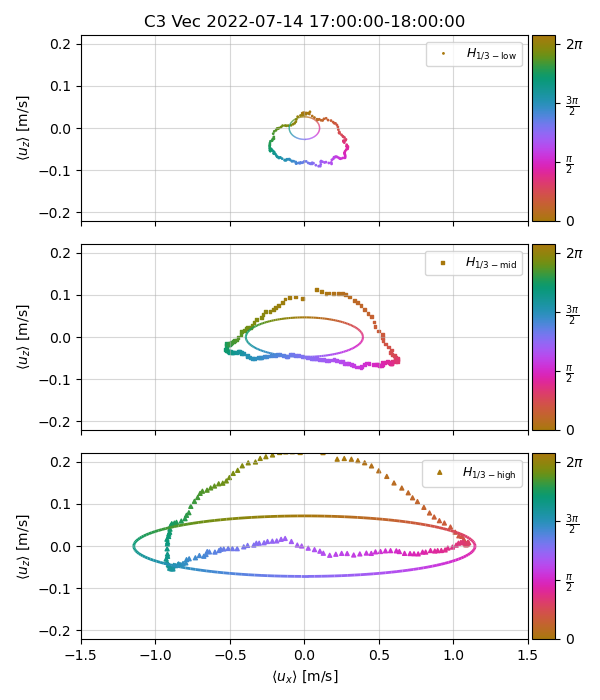

In [9]:
# Orbital motion scatter plots
mid = 'C3'
N = len(dfd_e[mid].keys()) # Number of zero-crossing waves
fig, axes = plt.subplots(figsize=(6,7), nrows=3, sharex=True, sharey=True)
for ax in axes:
    ax.grid(alpha=0.5)
# Mean cross-shore velocities (measured)
u_low = dfd_u[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
u_low_lin = dfd_u_lin[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
u_mid = dfd_u[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
u_mid_lin = dfd_u_lin[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
u_hig = dfd_u[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
u_hig_lin = dfd_u_lin[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
# Mean vertical velocities (measured)
w_low = dfd_w[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
print('w-low max: {:.2f}, w-low min: {:.2f}'.format(w_low.max(), w_low.min()))
w_low_lin = dfd_w_lin[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
w_mid = dfd_w[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
w_mid_lin = dfd_w_lin[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
w_hig = dfd_w[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
w_hig_lin = dfd_w_lin[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
# Ellipses
ex_low = dfd_evx[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
ey_low = dfd_evy[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
exl_low = dfd_elx[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
eyl_low = dfd_ely[mid].sort_index(axis=1).iloc[:,:N//3].mean(axis=1).values
ex_mid = dfd_evx[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
ey_mid = dfd_evy[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
exl_mid = dfd_elx[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
eyl_mid = dfd_ely[mid].sort_index(axis=1).iloc[:,N//3:2*N//3].mean(axis=1).values
ex_hig = dfd_evx[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
ey_hig = dfd_evy[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
exl_hig = dfd_elx[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
eyl_hig = dfd_ely[mid].sort_index(axis=1).iloc[:,2*N//3:].mean(axis=1).values
# Phase
phase = dfw_u.index.values
# Plot mean orbital excursion w/ phase as color
a0 = axes[0].scatter(u_low, w_low, c=phase, s=1, cmap=cmocean.cm.phase, 
    label=r'$H_\mathrm{1/3-low}$')
# Fit ellipse using SVD
# ellipse, angle, ae, be = rppl.fit_ellipse_svd(u_low, w_low, ax=axes[0], plot_ellipse=True, color='k')
# axes[0].plot(ex_low, ey_low, color='k')
# Medium wave heigths
a1 = axes[1].scatter(u_mid, w_mid, c=phase, marker='s', s=4, cmap=cmocean.cm.phase, 
    label=r'$H_\mathrm{1/3-mid}$')
# Fit ellipse using SVD
# ellipse, angle, ae, be = rppl.fit_ellipse_svd(u_mid, w_mid, ax=axes[1], plot_ellipse=True, color='k')
# axes[1].plot(ex_mid, ey_mid, color='k')
# Large wave heigths
a2 = axes[2].scatter(u_hig, w_hig, c=phase, marker='^', s=8, cmap=cmocean.cm.phase, vmin=0, 
    vmax=2*np.pi, label=r'$H_\mathrm{1/3-high}$')
# Fit ellipse using SVD
# ellipse, angle, ae, be = rppl.fit_ellipse_svd(u_hig, w_hig, ax=axes[2], plot_ellipse=True, color='k')
# axes[2].plot(ex_hig, ey_hig, color='k')
# Construct ellipse from mean parameters
am = dfd_ang[mid].sort_index()['a'].values[2*N//3:].mean()
bm = dfd_ang[mid].sort_index()['b'].values[2*N//3:].mean()
# Mean angles
sum_sin = np.sin(dfd_ang[mid].sort_index()['ang'].values[2*N//3:]).sum()
sum_cos = np.cos(dfd_ang[mid].sort_index()['ang'].values[2*N//3:]).sum()
ang_mean = np.arctan2(sum_sin, sum_cos)
rotation_matrix = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
t = np.linspace(0, 1, 1000, endpoint=False)
ellipse = np.sqrt(2) * np.c_[am*np.cos(2*np.pi*t), bm*np.sin(2*np.pi*t)]
ellipse = np.dot(rotation_matrix(ang_mean), ellipse.T).T
# axes[2].plot(ellipse[:,0], ellipse[:,1], color='r')
# Linear estimates
points = np.array([u_low_lin, w_low_lin]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(phase.min(), phase.max())
lc = LineCollection(segments, cmap=cmocean.cm.phase, norm=norm, linewidths=1.0)
lc.set_array(phase)
line = axes[0].add_collection(lc)
# Fit ellipse using SVD
# ellipsel, anglel, ael, bel = rppl.fit_ellipse_svd(u_low_lin, w_low_lin, ax=axes[0], color='k')
# Mid
points = np.array([u_mid_lin, w_mid_lin]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(phase.min(), phase.max())
lc = LineCollection(segments, cmap=cmocean.cm.phase, norm=norm, linewidths=1.5)
lc.set_array(phase)
line = axes[1].add_collection(lc)
# ellipsel, anglel, ael, bel = rppl.fit_ellipse_svd(u_mid_lin, w_mid_lin, ax=axes[1], color='k')
# High
points = np.array([u_hig_lin, w_hig_lin]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(phase.min(), phase.max())
lc = LineCollection(segments, cmap=cmocean.cm.phase, norm=norm, linewidths=2)
lc.set_array(phase)
line = axes[2].add_collection(lc)
# Ellipse
# axes[2].plot(exl_hig, eyl_hig, color='k')

# Colorbar
for ax in axes:
    cax = ax.inset_axes([1.01, 0.00, 0.05, 1.0], transform=ax.transAxes)
    fig.colorbar(a2, cax=cax)
    cmap = ListedColormap(['r', 'g', 'b'])
    cax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    # cax.set_ylabel('Phase')

for ax in axes:
    ax.legend(fontsize=9)
    ax.set_ylabel(r'$\langle u_z \rangle$ [m/s]')
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-0.22, 0.22])
axes[2].set_xlabel(r'$\langle u_x \rangle$ [m/s]')
axes[0].set_title('{} Vec {}-{}'.format(mid, t0, t1.time()))

plt.tight_layout()
fn_fig = os.path.join(figdir, 'phase_res_orbits_{}.png'.format(mid))
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
# plt.show()
plt.close()

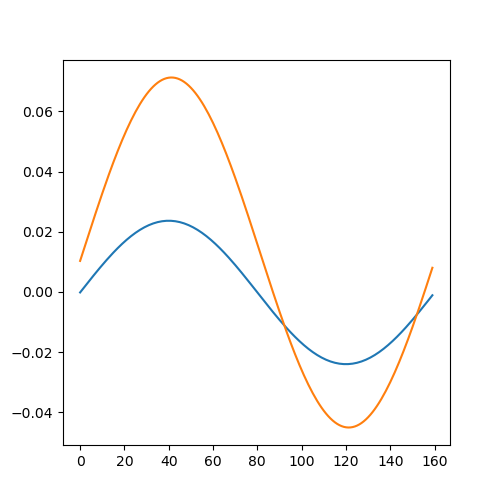

0.9999954204956171


In [34]:
ael
# ae
ellipsel
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(-ellipsel[:,1])
ax.plot(ellipse[:,1])

plt.show()
print(np.cos(angle))

Eccentricity of orbital excursions on top of the rock vs. LWT scatter plot.

Spectral comparison C1 vs. C3 vs. C6 Signatures vs. LWT from AST signals.